## Tasks

>1. Perform Text Classification using Multinomial Naive Bayes(already implemented in sklearn).
>2. Implement Naive Bayes on your own from scratch for text classification. 
>3. Compare Results of your implementation of Naive Bayes with one in Sklearn.

> Dataset - https://drive.google.com/drive/folders/17asj7qWkdqDYcPTVjgG-i71fX4Pt1oZM?usp=sharing



> ### Importing necessary libraries and packages

In [1]:
import pandas as pd
import numpy as np
import os
import os.path
import re
from string import punctuation
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

> ### Data Preparation 

In [2]:
# reading the stopwords which have collected from internet

def read_stopwords(path):    
        """ will take the file name and then traverse over the file to list out the stopwords

        Args:
            path (string): file name or the path

        Returns:
            list: a list of stopwords
        """        
        # reading the specified file using with command
        with open(path) as file:
            data = file.readlines()
        
        #list to store the stopwords
        stopwords = []
        
        #traversing over each line of the data read from the file
        for i in data:
            
            # removing the trailing or preceeding the spaces
            i = i.strip()
            
            # appending the word to the list
            stopwords.append(i)
        
        # returning the list
        return stopwords

# calling function to get stopwords from file which collected from the internet
stopwords = read_stopwords('stopwords.txt') 

In [3]:
# avoid special charecters, using punctuation in the string package# to eliminate the punctuations

punctuations = [i for i in punctuation]

>>  ### Creating Vocabulary dictionary

In [4]:
def read_data(path,stopwords):
    """ will take the path and read the documents in the location and then will create 
        a vocabulary dictionary which contain the frequencies of each word 

    Args:
        path (string): path where the text documents are located
        stopwords (list): a list of stopwords which needs to be excluded 

    Returns:
        dictionary: words dictionary with their frequencies
    """    
    # dictionary to store the words frequency 
    data = {}
    
    # storing the current loc for backup
    current_loc = os.getcwd()
    
    # listing out the directories in the specified path
    dirlist = os.listdir(path)
    
    
    # creating the dictionary to store the classes and their respective labeling value
    ylabels = {}
    
    # counter varaible to track the classes
    y_lables_c = 0
    
    #finding the number of directories
    num_dirs = len(dirlist)
    
    # using the tqdm for the progress bar,the value remains same
    for j in tqdm(range(num_dirs)):
        
        # current directory
        i = dirlist[j]
        
        # joining the directory to the path
        new_path = os.path.join(path,i)
        
        # changing the current directory with the modified path
        os.chdir(new_path)
        
        # travesing through each file in the current directory
        for file in os.listdir(new_path):
            
            # reading the file 
            with open(file,'r') as f:
                file_data = f.read()
                
            # searching for the words in the data using the regex module 
            tokens = re.compile('\w+').findall(file_data)
            
            # travesing on each word
            for word in tokens:
                # string the word and converting the string to lower 
                word = word.strip().lower()
                
                # only taking those words which are not part of stopwords and their length is greater than
                # 3 and the word is not part of punctuations and if the word is alphabets
                if word not in stopwords and len(word) > 3 and word not in punctuations and word.isalpha():
                    
                    # updating the frequency of the word if already there, else will initialize with 0
                    data[word] = data.get(word,0) + 1
        
        # for ease of use, labeling the class name in numeric way
        ylabels[i] = y_lables_c
        
        #updating the counter 
        y_lables_c += 1
    
    # changing the current directory back to the backed up location
    os.curdir = current_loc
    
    # returning the frequency dictionary and the y_labels dictionary
    return data,ylabels

In [5]:
# creating our vocabulory dictionary which will get the words and their frequency and classes dictionary

vocabulory,classes = read_data(r'D:\PY\20_newsgroups',stopwords)

  0%|          | 0/20 [00:00<?, ?it/s]

##### sorting the vocabulory dictionary based on the values

In [6]:
# dictionary to store the sorted words
sorted_vocabulory = {}

#sorting the dictionary keys basis of their values using sorted method in decreasing order
sorted_keys = sorted(vocabulory,key = vocabulory.get,reverse=True)

#traversing through all the keys and updating the sorted dictionary
for i in sorted_keys:
    sorted_vocabulory[i] = vocabulory[i]

##### lets plot the words and their frequencies

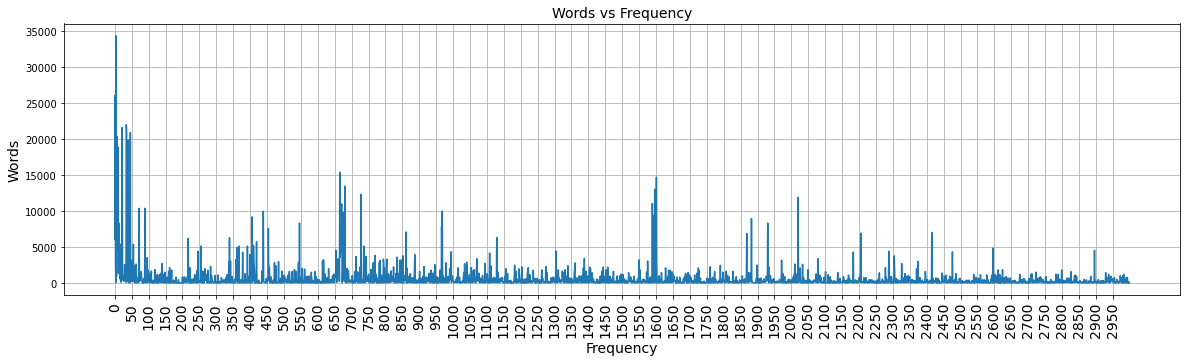

In [7]:
# taking the dictionary keys and values to the variables
words = list(vocabulory.keys())
frequencies = list(vocabulory.values())

# lets put limit to avoid, lesser frequency values
lower_limit = 0
upper_limit = 3000

# changing the plot size
plt.figure(figsize=(20,5))

# using the words might be tedias in this plot cause of long range, hence use number, since it does
# not really matter to look in the features
plt.plot(np.arange(len(words))[lower_limit:upper_limit],frequencies[lower_limit:upper_limit])
plt.title("Words vs Frequency",size = 14)
plt.xlabel("Frequency",size= 14)
plt.ylabel("Words",size = 14)

# giving the xticks for more detailed view
plt.xticks(np.arange(lower_limit,upper_limit,50),rotation = 90,size = 14)
plt.grid()
plt.show()

From the graph we can see that the frequency of the words after the around 3000 is very less near to be zero, so lets take the features as top 3000 words

In [8]:
# picking the top 3000 words as out features for now, we can tune this, later if we want to

features = [i for i,j in list(sorted_vocabulory.items())[:3000]]

In [9]:
# adding class as a target feature to the featur names.
features.append('Class')

> ### Building the dataset from the given documents

In [10]:
def get_words(file,vocabulory):
    """ this function will take the file and the read the data which includes only the features
        which are there in vocabulary

    Args:
        file (path): file to read the words 
        vocabulory (list): features which only needs to include
    """     
    
    # a list to store the words 
    words = []
    
    # reading the file
    with open(file,'r') as f:
        file_data = f.read()
    
    # listing out all the words which satisfy the below regex
    tokens = re.compile('\w+').findall(file_data)
    
    # traversing on each word
    for word in tokens:
        
        # striping out preceeding and exceeding space and converting the word to lower form
        word = word.strip().lower()
        
        # if the word is in vocabulary list
        if word in vocabulory:
            # appending to the words list 
            words.append(word)
    
    # returning the words
    return words

In [11]:
def prepare_data(path,vocabulory_list,y_labels):
    """''' will go to the specified path and read all the documents in the location one by one
        then will scan word by word and increase the frequency and will return the updated
        dataframe
    '''

    Args:
        path (string): pathe to read the documents
        vocabulory_list (list): features/words list
        y_labels (dictionary): dictionary with labeled classes

    Returns:
        array : an array with the rows which contain the frequencies of each feature over all documents
    """   

    # finding the features length 
    vocabulory_len = len(vocabulory_list)
    
    # to get the current location
    current_loc = os.getcwd()

    # creating the an array with the length of features
    freq_array = np.zeros(vocabulory_len,dtype=int)

    # accessing the directories list of current path
    dirlist = os.listdir(path)
    
    #finding the number of directories
    num_dirs = len(dirlist)
    
    # using the tqdm for the progress bar,the value remains same
    for j in tqdm(range(num_dirs)):

        # current directory
        i = dirlist[j]

        # adding the current directory to the path
        new_path = os.path.join(path,i)

        # changing the current location to new location
        os.chdir(new_path)

        # traversing through each document of the current directory
        for file in os.listdir(new_path):

            # creating an integer array with length of features length
            doc_row = np.zeros(vocabulory_len,dtype=int)

            #accessing the current class from y_labels dictionary
            doc_class = y_labels[i]

            # inserting the class in the end feature of array
            doc_row[-1] = doc_class

            # calling function to get the words of each file
            words = get_words(file,vocabulory_list)

            # traversing through each word of the words
            for word in words:

                # incrementing the frequency by 1 on each found of the word
                doc_row[vocabulory_list.index(word)] = doc_row[vocabulory_list.index(word)] + 1

            # concating the both array so that on every iteration we add a row for each document read
            freq_array = np.c_[freq_array,doc_row]
    
    # changing the current location back to actual one which we took backup
    os.curdir = current_loc

    # returning the array which will have the frequencies
    return freq_array

In [12]:
# we will get the dataframe with the features frequency having the rows as each document data

frequency_data = prepare_data(r'D:\PY\20_newsgroups',
    features,classes)

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
frequency_data.shape

(3001, 19999)

>> ### Creating Dataframe with the frequency data

In [14]:
freq_df = pd.DataFrame(frequency_data.T,columns=features)

In [15]:
freq_df.describe(include='all')

,news,cantaloupe,message,subject,lines,date,newsgroups,path,organization,state,...,beach,eating,lang,offense,micro,iowa,selected,missions,gerry,Class
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,...,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.00000,19999.000000,19999.000000,19999.000000,19999.000000
mean,1.715586,1.302515,1.097805,1.079554,1.044802,1.039452,1.020301,1.018551,0.992100,0.942197,...,0.008900,0.008900,0.008900,0.008900,0.008900,0.00890,0.008900,0.008900,0.008900,9.499175
std,1.480821,0.459467,0.554405,0.779540,0.362224,0.316075,0.230637,0.280916,0.309592,1.302624,...,0.128928,0.122973,0.148064,0.124589,0.151734,0.12658,0.117142,0.235428,0.203777,5.766959
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,9.000000
75%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,14.000000
max,30.000000,2.000000,24.000000,50.000000,15.000000,14.000000,15.000000,22.000000,8.000000,21.000000,...,7.000000,6.000000,6.000000,6.000000,9.000000,10.00000,5.000000,23.000000,10.000000,19.000000


>> ### saving dataset to the csv file

In [16]:
freq_df.to_csv('text_classification_prepared_data.csv',index=False)

> ## Training the Model

### Using sklearn MulitinomialNB classifier

##### splitting the data

In [17]:
y = freq_df['Class']

X = freq_df.drop('Class',axis = 1)

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 0)

In [19]:
# lets check the shapes of Train and test data

print("Train X {} Train y {}".format(X_train.shape,y_train.shape))
print("Test X {} Test y {}".format(X_test.shape,y_test.shape))

Train X (15999, 3000) Train y (15999,)
Test X (4000, 3000) Test y (4000,)


#### Training the model

In [20]:
# creating the object for classifier

clf = MultinomialNB()

# fitting the data on the classifier object
clf.fit(X_train,y_train)

# testing the classifer with y_test data and storing it
y_pred = clf.predict(X_test)

# checking the peformance of the model using confusion_matrix and classification_report

print(confusion_matrix(y_test,y_pred))

print(classification_report(y_test,y_pred))

[[159   0   0   0   0   0   0   1   0   0   0   1   0   0   0   2   1   0
    0  29]
 [  0 152  18  12   6   3   4   0   0   0   0   0   4   0   2   0   0   0
    0   0]
 [  0   1 172   9   1   8   4   0   0   0   0   0   2   0   0   0   0   0
    0   0]
 [  0   3   8 134  25   2   4   1   0   0   0   3   2   0   0   0   0   0
    0   0]
 [  0   2   1  22 167   0   6   1   0   0   0   0   5   0   0   0   0   0
    0   0]
 [  0  11  25   4   4 146   1   0   0   0   0   0   2   1   0   0   0   0
    0   0]
 [  0   1   1   4   0   0 189   6   1   0   0   0   2   0   0   0   1   0
    0   0]
 [  0   0   0   0   1   0   6 190   4   0   1   0   2   0   1   0   1   0
    0   0]
 [  0   0   0   0   0   0   7   6 194   0   0   0   1   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   2   1   0 180   4   0   0   0   1   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   1   0   3 181   0   0   0   0   0   0   0
    0   0]
 [  0   1   0   1   0   1   1   0   1   0   0 179   1   0   0   0

## Implementing MulitnomialNB classifier

In [21]:
def fit(X_train,y_train):
    '''
    
    return : dictionary with the frequency count of each feature
    '''
   
    # initializing the count dicionary
    count = {}
    
    # initializing the total count with 0
    count['total_count'] = 0
    
    # storing the classes 
    classes = list(set(y_train))
    
    # finding the number of classes
    num_classes = len(classes)
    
    for i in tqdm(range(num_classes)): # for each class
        
        # current class 
        current_class = classes[i]
        
        # creating dictionary for each class
        count[current_class] = {}
        
        # storing the current class data points using the boolean array
        current_class_rows = (y_train == current_class)
        
        # storing the current class X data points 
        X_train_current = X_train[current_class_rows]
        
        # storing the current class y data points
        y_train_current = y_train[current_class_rows]
        
        # finding the features count 
        num_features = X_train.shape[1]
        
        # initializing the current class total count 
        count[current_class]['total_count'] = 0
        
        # traversing through all the features
        for j in range(num_features):
            
            # finding the count of the jth word appear in the current class 
            count[current_class][j] = X_train_current[:,j].sum()
            
            #updating the total count value for current class
            count[current_class]['total_count'] += count[current_class][j]
        
        #updating the total count of words in all the documents
        count['total_count'] += count[current_class]['total_count']
        
    return count

In [22]:
def probability(dictionary,x,current_class):
    '''
    '''
    
    # calculating the log probalities to avoid zero probabilities issue
    # using the Mulitnomial Naive Bayes thearom formula to calculate the prior probability for particular class
    output = np.log(dictionary[current_class]['total_count']) - np.log(dictionary['total_count'])
    
    # finding the total number of features
    num_features = len(x)
    
    # travesing throught each feature
    for j in range(num_features):
        xj = x[j]
        
        # ignoring the features with values zero to avoid unnecessary calculations
        if xj == 0:
            continue
        
        # using the Mulitnomial Naive Bayes thearom formula to calculate the likelihood probality
        # also added the laplase correction to avoid the zero probabilites problem
        current_class_with_xj = dictionary[current_class][j] + 1
        current_class_total_count = dictionary[current_class]['total_count'] + num_features
        
        # finding the log probabilities
        current_xj_prob = np.log(current_class_with_xj) - np.log(current_class_total_count)
        
        # adding the prior probability value which compute in the beginning 
        output += current_xj_prob
    
    return output

In [23]:
def predict_single_point(dictionary,x):
    '''
    
    '''
    # storing the class names from the dictionary keys
    classes = dictionary.keys()
    
    # assuming the initial probability is a big negative number
    best_prob = -1000
    
    # initializing the best_class to track the best predicted class
    best_class = -1
    
    # using variable in order the best class in the first run
    first_run = True
    
    for current_class in classes:
        
        # to exclude this run since total_count is one of the key in the dictionary
        if(current_class == 'total_count'):
            continue
        
        # calling probability funtion to compute the probability for current class
        current_class_prob = probability(dictionary,x,current_class)
        
        if (first_run or current_class_prob > best_prob):
            
            #updating the best class and probabilities
            best_prob = current_class_prob
            best_class = current_class
        
        first_run = False
        
    # returning the best predicted class
    return best_class

In [24]:
def predict(dictionary,X_test):
    ''' inputs :
            dictionary: which will be computed while the fit function
            X_test : nd array with test data
        
        return : will predict the probabilities for all the classes with respect to the words in the document and will
        return it
        '''
    # a list to store the predicted class
    y_pred = []
    
    # traversing through the each data points of testing data
    for j in  tqdm(range(X_test.shape[0])):
        
        x = X_test[j]
        
        # calling predict_single_point function to get the prediction of a single data point
        x_class = predict_single_point(dictionary,x)
        
        # appending to the y_pred list
        y_pred.append(x_class)
        
    return y_pred

In [25]:
# target data
y_ = freq_df['Class'].values

# input features data
X_ = freq_df.drop('Class',axis = 1).values

# splitting the train and test data

X_train_,X_test_,y_train_,y_test_ = train_test_split(X_,y_,test_size = 0.25,random_state=0)

### Fitting the data on our classifier

In [26]:
dictionary = fit(X_train_,y_train_)

  0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
y_pred_ = predict(dictionary,X_test_)

  0%|          | 0/5000 [00:00<?, ?it/s]

### Generating the Classification Report

In [28]:
print(confusion_matrix(y_test_,y_pred_))
print(classification_report(y_test_,y_pred_))

[[198   0   0   0   0   0   0   0   1   1   0   1   0   2   0   1   0   1
    1  27]
 [  0 197  20  18   7   6   0   0   0   0   0   0   3   2   0   0   0   0
    0   0]
 [  0   6 213  12   4  11   2   0   0   0   0   0   1   0   0   0   0   0
    0   0]
 [  0   4   9 181  37   1   4   1   0   0   0   1   2   0   0   0   0   0
    0   0]
 [  0   2   1  26 198   1   6   0   0   0   0   1   1   0   0   0   0   0
    0   0]
 [  1  16  24   3   4 195   0   0   0   0   0   0   0   2   0   0   0   0
    0   0]
 [  0   0   1   2   1   1 243   8   1   0   0   0   1   0   0   0   0   0
    0   0]
 [  0   0   0   1   0   1   7 240   3   0   0   0   2   0   1   0   3   0
    0   0]
 [  0   0   0   0   0   0   6   5 250   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   1   1   0 224   3   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   1   2   0   3 222   0   0   0   0   0   0   0
    1   0]
 [  0   1   0   0   0   2   0   0   1   0   0 226   1   0   0   0

#### As we can see the results are almost equal, infact our model is slight better if compared to sklearn report